In [1]:
import os 
import shutil
import random
import glob
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline

Directory structure to convert pascalVOC annotations to data required by yolo model <br/>
Dataset: (all jpegs and xml should be in same folder images)

> images: img_1.jpg, img_1.xml...



In [2]:
# !unzip Dataset.zip

Clone the YOLOv5 repo

In [3]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 5437, done.
remote: Total 5437 (delta 0), reused 0 (delta 0), pack-reused 5437
Receiving objects: 100% (5437/5437), 8.07 MiB | 29.93 MiB/s, done.
Resolving deltas: 100% (3713/3713), done.


Code to convert PascalVOC Annotations to YOLO data format. <br/>
Directory structure will be: <br/>
Dataset: <br/>

> images: car_0.jpg,car_0.xml,car_1.jgp....<br/>
> labels: car_0.txt,car_1.txt....<br>
> images.txt



    
    


In [ ]:
dirs = ['Dataset/images']
classes = ['license_plate']

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)

    return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

cwd = getcwd()

for dir_path in dirs:
    full_dir_path = cwd + '/' + dir_path
    output_path = cwd +'/Dataset' +'/labels/'

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_paths = getImagesInDir(full_dir_path)
    list_file = open(full_dir_path + '.txt', 'w')

    for image_path in image_paths:
        list_file.write(image_path + '\n')
        convert_annotation(full_dir_path, output_path, image_path)
    list_file.close()

    print("Finished processing: " + dir_path)

Load the txt files containing test and train img names into lists

In [ ]:
with open('/content/test.txt') as f:
    test_imgs = f.read().splitlines()

with open('/content/trainval.txt') as f:
    trainval_imgs = f.read().splitlines()

In [ ]:
len(trainval_imgs),len(test_imgs)

(500, 169)

In [ ]:
random.shuffle(trainval_imgs)

Make train and val sets

In [ ]:
train_imgs=trainval_imgs[:400]
val_imgs=trainval_imgs[400:]

In [ ]:
len(train_imgs),len(val_imgs)

(400, 100)

Crete folders for train,test and val (Required by YOLOv5)

In [ ]:
!mkdir /content/Dataset/images/train
!mkdir /content/Dataset/labels/train
!mkdir /content/Dataset/images/val
!mkdir /content/Dataset/labels/val
!mkdir /content/Dataset/images/test
!mkdir /content/Dataset/labels/test

In [ ]:
data_dir='/content/Dataset/images/'
label_dir='/content/Dataset/labels/'

Load the images and labels in correct directories

In [ ]:
for img in train_imgs:
  shutil.copy(data_dir+img+'.jpg',data_dir+'train')
  shutil.copy(label_dir+img+'.txt',label_dir+'train')

In [ ]:
for img in test_imgs:
  shutil.copy(data_dir+img+'.jpg',data_dir+'test')
  shutil.copy(label_dir+img+'.txt',label_dir+'test')

In [ ]:
for img in val_imgs:
  shutil.copy(data_dir+img+'.jpg',data_dir+'val')
  shutil.copy(label_dir+img+'.txt',label_dir+'val')

In [ ]:
%cd yolov5

/content/yolov5


Load weights for different models. (We'll be using the small model to reduce inference and training time and we only have around 500 images in our training set)

In [ ]:
!bash weights/download_weights.sh 

100% 14.1M/14.1M [00:00<00:00, 63.1MB/s]

100% 41.1M/41.1M [00:00<00:00, 56.8MB/s]

100% 90.2M/90.2M [00:01<00:00, 62.4MB/s]

100% 168M/168M [00:02<00:00, 74.1MB/s]



Model Training (Transfer Learning)

In [ ]:
!python train.py --img 640 --batch 8 --epochs 30 --data ../licence_plates.yaml --cfg ./models/yolov5s.yaml --weights 'yolov5s.pt' --device 0

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v4.0-138-ged2c742 torch 1.8.0+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=8, bucket='', cache_images=False, cfg='./models/yolov5s.yaml', data='../licence_plates.yaml', device='0', entity=None, epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp4', single_cls=False, sync_bn=False, total_batch_size=8, weights='yolov5s.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-03-22 15:39:23.994279: I tensorflow/stream_executor/platform/de

mAP@.5 = 0.924 <br/>
mAP@.5:0.95 = 0.376

Inference on all 169 images in our test data

In [ ]:
!python detect.py --source /content/Dataset/images/test/  --weights /content/yolov5/runs/train/exp4/weights/best.pt --conf 0.4

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/Dataset/images/test/', update=False, view_img=False, weights=['/content/yolov5/runs/train/exp4/weights/best.pt'])
YOLOv5 🚀 v4.0-138-ged2c742 torch 1.8.0+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS
image 1/169 /content/Dataset/images/test/car_100.jpg: 480x640 Done. (0.010s)
image 2/169 /content/Dataset/images/test/car_104.jpg: 320x640 1 license_plate, Done. (0.010s)
image 3/169 /content/Dataset/images/test/car_108.jpg: 416x640 1 license_plate, Done. (0.010s)
image 4/169 /content/Dataset/images/test/car_120.jpg: 384x640 1 license_plate, Done. (0.010s)
image 5/169 /content/Dataset/images/test/car_121.jpg: 480x640 Done. (0.010s)
image 6/169 /content/Dataset/images/test/car_131.jpg: 448x640 1 lic

In [1]:
3.372/169

0.01995266272189349

mean inference time on a gpu is only 20 miliseconds. (Close to 50 FPS)

In [ ]:
!python detect.py --source /content/Dataset/images/test/  --weights /content/yolov5/runs/train/exp4/weights/best.pt --conf 0.4 --device cpu

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='cpu', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/Dataset/images/test/', update=False, view_img=False, weights=['/content/yolov5/runs/train/exp4/weights/best.pt'])
YOLOv5 🚀 v4.0-138-ged2c742 torch 1.8.0+cu101 CPU

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS
image 1/169 /content/Dataset/images/test/car_100.jpg: 480x640 Done. (0.267s)
image 2/169 /content/Dataset/images/test/car_104.jpg: 320x640 1 license_plate, Done. (0.178s)
image 3/169 /content/Dataset/images/test/car_108.jpg: 416x640 1 license_plate, Done. (0.227s)
image 4/169 /content/Dataset/images/test/car_120.jpg: 384x640 1 license_plate, Done. (0.210s)
image 5/169 /content/Dataset/images/test/car_121.jpg: 480x640 Done. (0.258s)
image 6/169 /content/Dataset/images/test/car_131.jpg: 448x640 1 license_plate, Done. (0.24

In [4]:
42.372/169

0.2507218934911243

It's a bit high on colab cpu, 250 miliseconds

In [5]:
31.485/169

0.18630177514792898

In my local setup, Average inferecene time for all test images is 0.18s(around 6 FPS). We can reduce the inference time significantly by using quantization or model pruning. Currently mAP@.5 is 0.924, if we are fine with the mean average precision to be around 0.80 then infernce time on cpu can be reduced by a large margin.

Plotting some of the images:

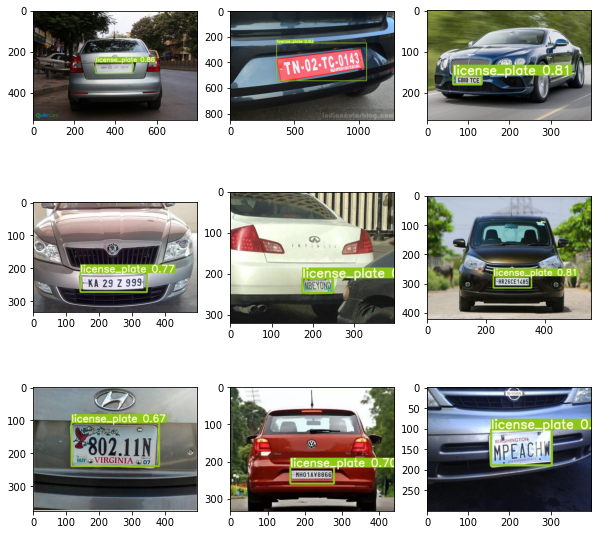

In [18]:
w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = mpimg.imread(f'yolov5/runs/detect/exp2/{test_imgs[i]}.jpg')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()